In [1]:
# %%
import sys
import torch
sys.path.append('..')
# sys.path.append('/system/user/beck/pwbeck/projects/regularization/ml_utilities')
from pathlib import Path
from typing import Union
from ml_utilities.torch_models.base_model import BaseModel
from ml_utilities.torch_models import get_model_class
from omegaconf import OmegaConf

from erank.utils import load_directions_matrix_from_task_sweep
import matplotlib.pyplot as plt
gpu_id = 2 

/system/apps/userenv/beck/erank/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load matrix

In [2]:
p = '/system/user/beck/pwbeck/projects/regularization/erank/outputs/f_mnist-2.0-taskidxXXX_260622_110634/outputs'
dir_matrix = load_directions_matrix_from_task_sweep(p, device=gpu_id)
dir_matrix.requires_grad_(True)

Loading /system/user/beck/pwbeck/projects/regularization/erank/outputs/f_mnist-2.0-taskidxXXX_260622_110634/outputs/f_mnist-2.0-taskidx3-seed0_260622_110648: 100%|██████████| 10/10 [00:03<00:00,  2.53it/s]


tensor([[-0.0005, -0.0005, -0.0004,  ..., -0.0032,  0.0077, -0.0123],
        [-0.0044, -0.0045, -0.0043,  ..., -0.0023,  0.0065, -0.0126],
        [-0.0035, -0.0035, -0.0034,  ...,  0.0005,  0.0075, -0.0096],
        ...,
        [-0.0034, -0.0034, -0.0034,  ..., -0.0009,  0.0030, -0.0107],
        [-0.0011, -0.0011, -0.0012,  ..., -0.0041,  0.0075, -0.0082],
        [-0.0046, -0.0046, -0.0050,  ..., -0.0013,  0.0027, -0.0132]],
       device='cuda:2', requires_grad=True)

In [3]:
dir_matrix.shape, dir_matrix.device, dir_matrix.requires_grad

(torch.Size([10, 669706]), device(type='cuda', index=2), True)

## erank

In [4]:
def erank(matrix_A: torch.Tensor, center_matrix_A: bool=False) -> torch.Tensor:
        """Calculates the effective rank of a matrix.

        Args:
            matrix_A (torch.Tensor): Matrix of shape m x n. 
            center_matrix_A (bool): Center the matrix 

        Returns:
            torch.Tensor: Effective rank of matrix_A
        """
        assert matrix_A.ndim == 2
        _, s, _ = torch.pca_lowrank(matrix_A, center=center_matrix_A, niter=1, q=min(matrix_A.shape[0], matrix_A.shape[1]))
        # s = torch.square(s) / (s.shape[0] - 1)

        # normalizes input s -> scale independent!
        return torch.exp(torch.distributions.Categorical(s).entropy())

In [5]:
er = erank(dir_matrix)
er

tensor(9.1032, device='cuda:2', grad_fn=<ExpBackward>)

In [6]:
# er.backward()

## normalize directions

In [7]:
norm_dir_matrix = dir_matrix / torch.linalg.norm(dir_matrix, ord=2, dim=1, keepdim=True)

In [8]:
torch.linalg.norm(dir_matrix, ord=2, dim=1, keepdim=True), torch.linalg.norm(norm_dir_matrix, ord=2, dim=1, keepdim=True)

(tensor([[11.7831],
         [ 9.9273],
         [12.0242],
         [11.0410],
         [11.1749],
         [11.7312],
         [10.3839],
         [10.7438],
         [12.8635],
         [11.3913]], device='cuda:2', grad_fn=<CopyBackwards>),
 tensor([[1.0000],
         [1.0000],
         [1.0000],
         [1.0000],
         [1.0000],
         [1.0000],
         [1.0000],
         [1.0000],
         [1.0000],
         [1.0000]], device='cuda:2', grad_fn=<CopyBackwards>))

In [9]:
erank(dir_matrix), erank(norm_dir_matrix)

(tensor(9.1032, device='cuda:2', grad_fn=<ExpBackward>),
 tensor(9.1280, device='cuda:2', grad_fn=<ExpBackward>))

## Analyse sensitivity of erank on norm of update vector

Here the erank and the singular values of the matrix = cat([pretrain_diffs, [norm_vec, 0,0, ...]]) is calculated.

In [10]:
norm_update_vec = 10

delta = torch.zeros(size=(1,dir_matrix.shape[1])).to(dir_matrix)
delta[0] = norm_update_vec
matrix1 = torch.cat([delta, dir_matrix], dim=0)
_, s, _ = torch.svd_lowrank(matrix1)
s, erank(matrix1)

(tensor([8183.6841,   25.2156,    9.6559,    8.7938,    8.4171,    8.2833],
        device='cuda:2', grad_fn=<SvdHelperBackward>),
 tensor(1.0975, device='cuda:2', grad_fn=<ExpBackward>))

In [11]:
norm_update_vec = 1e-3

delta = torch.zeros(size=(1,dir_matrix.shape[1])).to(dir_matrix)
delta[0] = norm_update_vec
matrix1 = torch.cat([delta, dir_matrix], dim=0)
_, s, _ = torch.svd_lowrank(matrix1)
s, erank(matrix1)

(tensor([25.2210,  9.6679,  9.0288,  8.8696,  8.5968,  7.7423], device='cuda:2',
        grad_fn=<SvdHelperBackward>),
 tensor(9.3705, device='cuda:2', grad_fn=<ExpBackward>))

The erank is sensitive to length of update vectors.

In [25]:
def erank_sv_norm_update_vector_sweep(dir_matrix, normalize_dir_matrix: bool = False):
    erank_vals = []
    singular_vals = []
    vec_norms = torch.logspace(-4, 1, 20)
    for n in vec_norms:
        delta = torch.zeros(size=(1,dir_matrix.shape[1])).to(dir_matrix)
        delta[0] = n
        matrix1 = torch.cat([delta, dir_matrix], dim=0)
        if normalize_dir_matrix:
            # normalize matrix
            matrix1 = matrix1 / torch.linalg.norm(matrix1, ord=2, dim=1, keepdim=True)
        erank_vals.append(erank(matrix1).item())
        _, s, _ = torch.svd_lowrank(matrix1)
        singular_vals.append(s.detach().cpu().numpy())
    return vec_norms, erank_vals, singular_vals

In [26]:
# make plot erank vs. appended vector norm
# def erank_vs_update_step_norm(dir_matrix, vals=20)
vec_norms, erank_vals, singular_vals = erank_sv_norm_update_vector_sweep(dir_matrix, normalize_dir_matrix=False)

(5, 60)

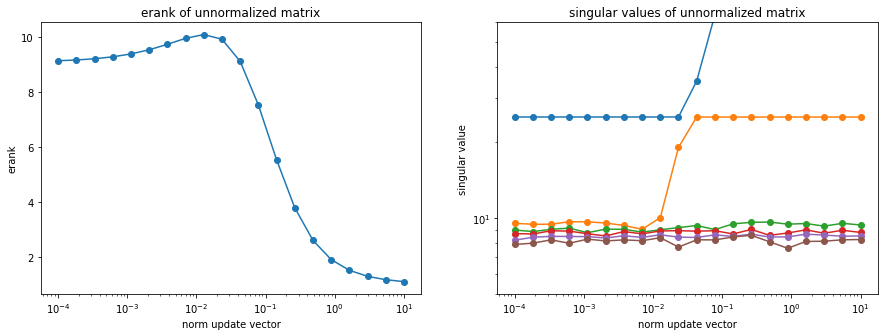

In [27]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(vec_norms, erank_vals, 'o-')
plt.xscale('log')
plt.ylabel('erank')
plt.xlabel('norm update vector')
plt.title('erank of unnormalized matrix')

plt.subplot(1,2,2)
plt.plot(vec_norms, singular_vals, 'o-')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('singular value')
plt.xlabel('norm update vector')
plt.title('singular values of unnormalized matrix')
plt.ylim(5, 60)

In [15]:
# make same plot of normalized matrix
vec_norms, erank_vals, singular_vals = erank_sv_norm_update_vector_sweep(dir_matrix, normalize_dir_matrix=True)

Text(0.5, 1.0, 'singular values of normalized matrix')

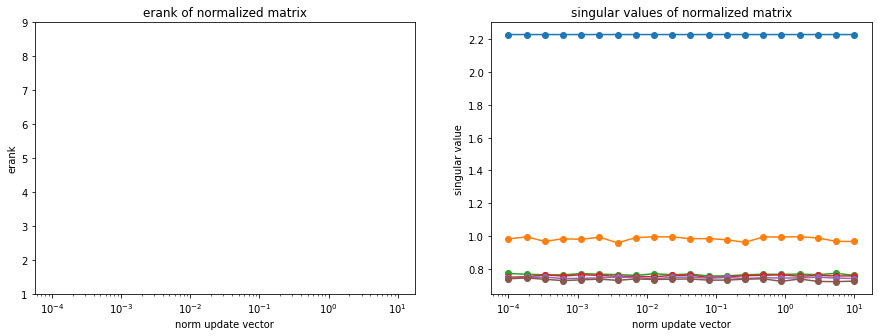

In [16]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(vec_norms, erank_vals, 'o-')
plt.xscale('log')
plt.ylim(1,9)
plt.ylabel('erank')
plt.xlabel('norm update vector')
plt.title('erank of normalized matrix')

plt.subplot(1,2,2)
plt.plot(vec_norms, singular_vals, 'o-')
plt.xscale('log')
plt.ylabel('singular value')
plt.xlabel('norm update vector')
plt.title('singular values of normalized matrix')


## Same analysis with unit direction matrix

In [17]:
diag = torch.eye(10)
vec_norms, erank_vals, singular_vals = erank_sv_norm_update_vector_sweep(diag, normalize_dir_matrix=False)

(0.0, 3.0)

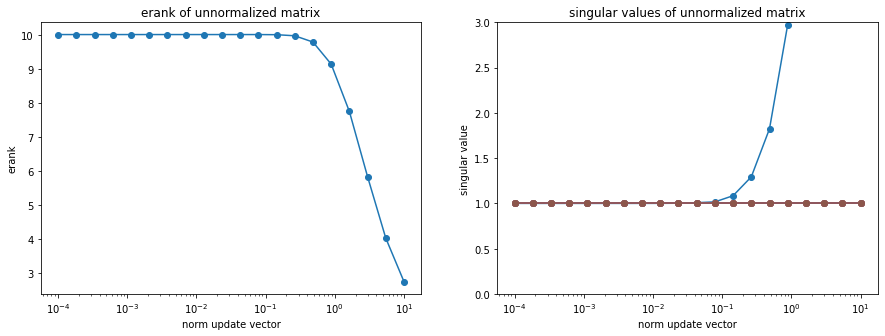

In [18]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(vec_norms, erank_vals, 'o-')
plt.xscale('log')
plt.ylabel('erank')
plt.xlabel('norm update vector')
plt.title('erank of unnormalized matrix')

plt.subplot(1,2,2)
plt.plot(vec_norms, singular_vals, 'o-')
plt.xscale('log')
# plt.yscale('log')
plt.ylabel('singular value')
plt.xlabel('norm update vector')
plt.title('singular values of unnormalized matrix')
plt.ylim(0, 3)

In [19]:
diag = torch.eye(10)
vec_norms, erank_vals, singular_vals = erank_sv_norm_update_vector_sweep(diag, normalize_dir_matrix=True)

Text(0.5, 1.0, 'singular values of normalized matrix')

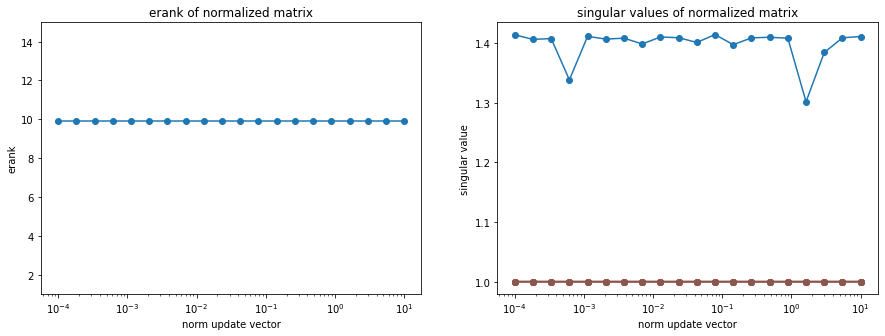

In [20]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(vec_norms, erank_vals, 'o-')
plt.xscale('log')
plt.ylim(1,15)
plt.ylabel('erank')
plt.xlabel('norm update vector')
plt.title('erank of normalized matrix')

plt.subplot(1,2,2)
plt.plot(vec_norms, singular_vals, 'o-')
plt.xscale('log')
plt.ylabel('singular value')
plt.xlabel('norm update vector')
plt.title('singular values of normalized matrix')

In [21]:
erank(diag)

tensor(10.0000)